In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

In [4]:
path = 'data/mnist/'

In [5]:
import os
os.makedirs(path, exist_ok=True)

In [6]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [7]:
# get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

In [8]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

### Normalize

In [9]:
mean = x.mean()
std = x.std()

In [10]:
x = (x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.30728981, -3.1638146e-07, 0.99999934)

In [11]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.0058509219, 0.99243325)

### Plot helpers

In [12]:
def show(img, title=None):
    plt.imshow(img, cmap="gray")
    if title is not None: plt.title(title)

In [13]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

### Plots

In [14]:
x_valid.shape

(10000, 784)

In [15]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

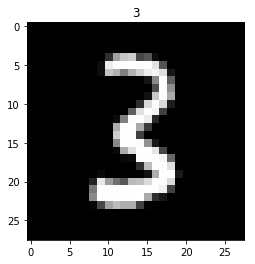

In [16]:
show(x_imgs[0], y_valid[0])

In [17]:
y_valid.shape

(10000,)

In [18]:
y_valid[0]

3

In [19]:
x_imgs[0, 10:15, 10:15]

array([[-0.42452, -0.42452, -0.42452, -0.42452,  0.17294],
       [-0.42452, -0.42452, -0.42452,  0.78312,  2.43567],
       [-0.42452, -0.27197,  1.20261,  2.77889,  2.80432],
       [-0.42452,  1.76194,  2.80432,  2.80432,  1.73651],
       [-0.42452,  2.20685,  2.80432,  2.80432,  0.40176]], dtype=float32)

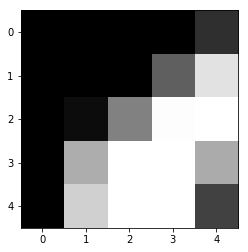

In [20]:
show(x_imgs[0, 10:15, 10:15])

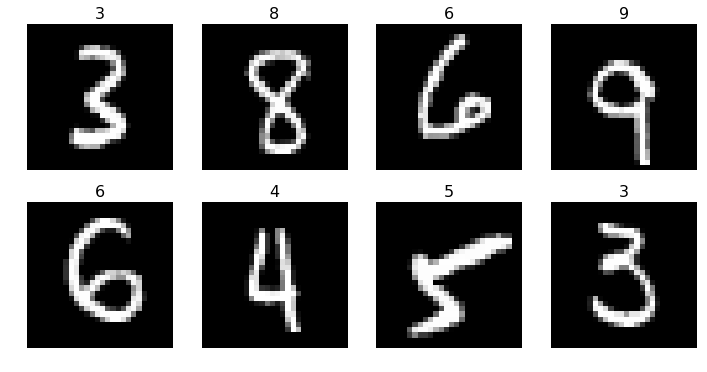

In [21]:
plots(x_imgs[:8], titles = y_valid[:8])

In [22]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

import torch.nn as nn

In [24]:
net = nn.Sequential(
    nn.Linear(28*28,10),
    nn.LogSoftmax()
).cuda()

In [25]:
md = ImageClassifierData.from_arrays(path,(x,y),(x_valid,y_valid))

In [26]:
x.shape

(50000, 784)

In [27]:
loss = nn.NLLLoss()
metrics = [accuracy]
opt = optim.Adam(net.parameters())

### Fitting the model

In [28]:
fit(net,md,epochs=1, crit=loss, opt=opt, metrics=metrics)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.303241   0.288219   0.915506  



[0.2882188, 0.91550557324840764]

In [29]:
def binary_loss(y,p):
    return np.mean(-(y*np.log(p) + (1-y)*np.log(1-p)))

In [30]:
acts = np.array([1,0,0,1])
preds = np.array([0.9,0.1,0.2,0.8])
binary_loss(acts,preds)

0.164252033486018

In [31]:
preds = predict(net, md.val_dl)

In [32]:
preds.shape

(10000, 10)

In [33]:
preds.argmax(axis=1)[:5]

array([3, 8, 6, 9, 6])

In [34]:
preds = preds.argmax(1)

In [35]:
np.mean(preds == y_valid)

0.91510000000000002

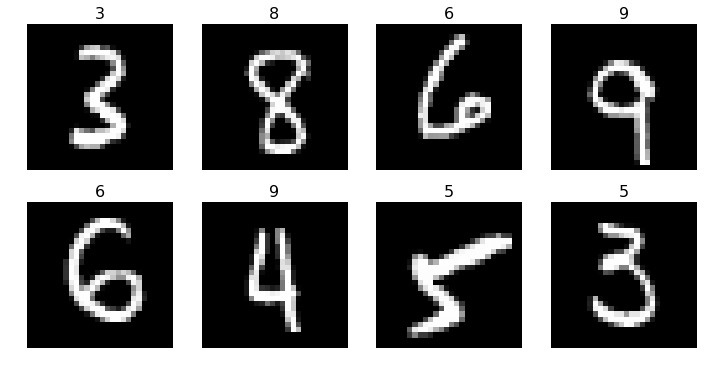

In [36]:
plots(x_imgs[:8],titles=preds[:8])

## Defining Logistic Regression Ourselves

In [41]:
torch.randn(3,4).cuda()*3


-3.9676 -1.7794  2.0849  2.1139
 3.7731 -0.6235  3.2971  5.0007
-5.6761  0.0586  1.6610 -0.3835
[torch.cuda.FloatTensor of size 3x4 (GPU 0)]

In [37]:
def get_weights(dims): return nn.Parameter(torch.randn(dims)/dims[0])

In [45]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights([28*28,10])
        self.l1_b = get_weights([10])
        
    def forward(self,x):
        x = x.view(x.size(0),-1)
        x = torch.matmul(x, self.l1_w) + self.l1_b
        x = torch.log(torch.exp(x)/(torch.exp(x).sum(dim=0)))
        return x

In [46]:
net2 = LogReg().cuda()
opt = optim.Adam(net2.parameters())

In [47]:
fit(net2, md, epochs=1, crit = loss, opt=opt, metrics=metrics) 

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      2.446715   2.395236   0.910032  



[2.3952358, 0.91003184713375795]